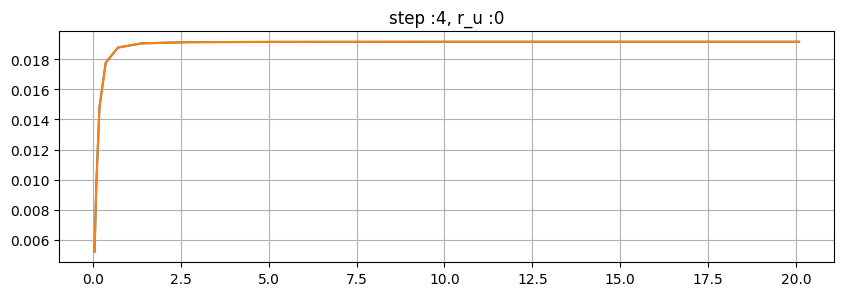

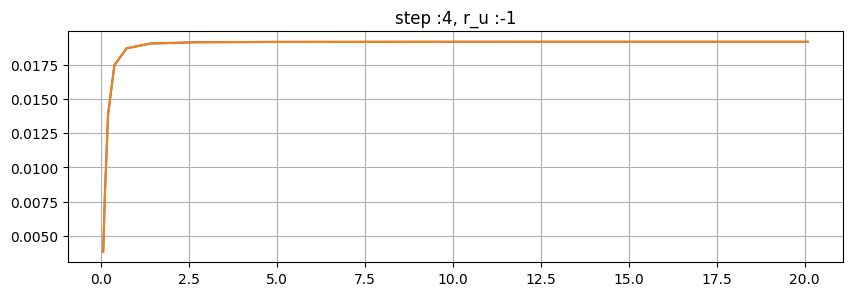

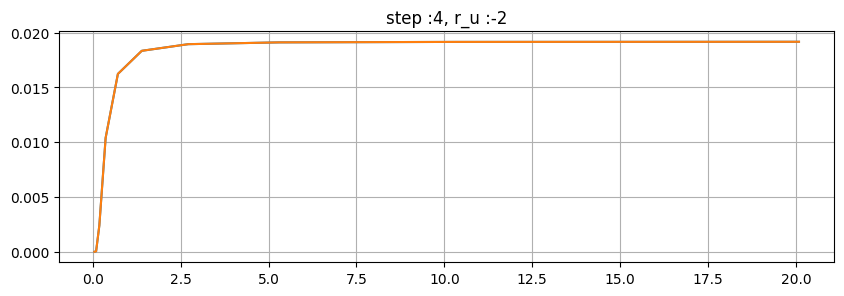

/tmp/ipykernel_582200/3456376136.py:65: RuntimeWarning: divide by zero encountered in log
  ret = np.exp(log_prefactor + np.log(erf_diff))


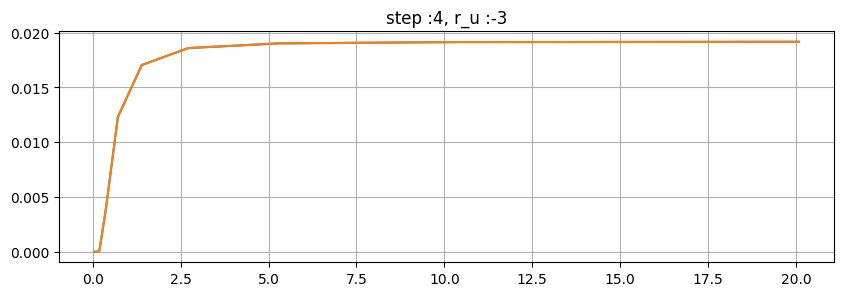

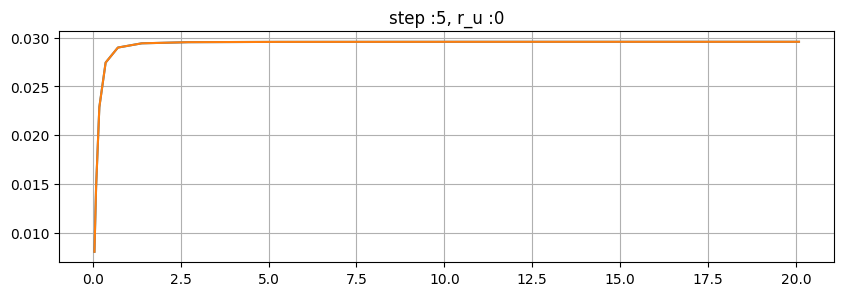

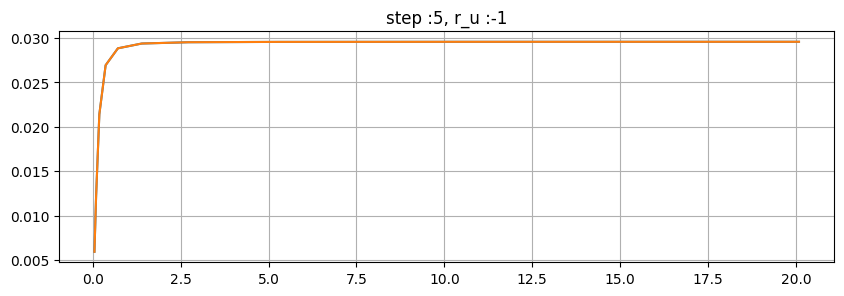

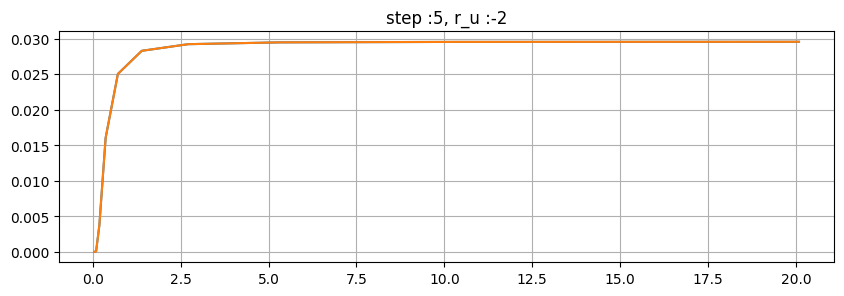

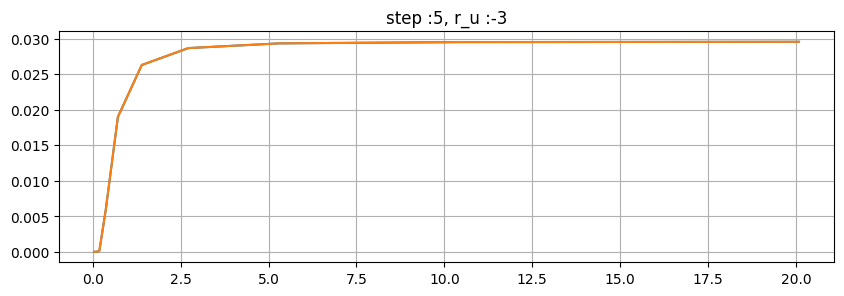

In [40]:
import torch
import numpy as np
from scipy.integrate import quad
from scipy.special import erf, erfc
import matplotlib.pyplot as plt
import math

def integral_quad(lambda_s, lambda_t, lambda_u, betas):
    def _integrand(x, beta):
        return np.exp(x - beta**2 * (x - lambda_u)**2)
    results = []
    for beta in betas:
        val, _ = quad(_integrand, lambda_s, lambda_t, args=(beta,))
        results.append(val)
    return np.array(results)

def integral_torch(lambda_s, lambda_t, lambda_u, betas):
    lambda_s = torch.tensor(lambda_s, device='cuda:0')
    lambda_t = torch.tensor(lambda_t, device='cuda:0')
    lambda_u = torch.tensor(lambda_u, device='cuda:0')
    betas = torch.tensor(betas, device='cuda:0')

    sqrt_pi = math.sqrt(math.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    prefactor = 0.5 * sqrt_pi * betas_inv * torch.exp(lambda_u + 0.25 * betas_sq_inv)

    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    ret = prefactor * (torch.erf(err_arg_t) - torch.erf(err_arg_s))
    return ret.data.cpu().numpy()

def integral_torch(lambda_s, lambda_t, lambda_u, betas):
    lambda_s = torch.tensor(lambda_s, device='cuda:0')
    lambda_t = torch.tensor(lambda_t, device='cuda:0')
    lambda_u = torch.tensor(lambda_u, device='cuda:0')
    betas = torch.tensor(betas, device='cuda:0')

    sqrt_pi = math.sqrt(math.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    prefactor = 0.5 * sqrt_pi * betas_inv * torch.exp(lambda_u + 0.25 * betas_sq_inv)

    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    ret = prefactor * (torch.erf(err_arg_t) - torch.erf(err_arg_s))
    return ret.data.cpu().numpy()

def get_erf_diff_numpy(a, b):
    diff_stable = erfc(b) * (1 - np.exp(np.log(erfc(a))-np.log(erfc(b))))
    return diff_stable

def integral_numpy_closed(lambda_s, lambda_t, lambda_u, betas):
    sqrt_pi = math.sqrt(math.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    log_prefactor = np.log(0.5) + np.log(sqrt_pi) + np.log(betas_inv) + (lambda_u + 0.25 * betas_sq_inv)

    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    erf_diff = get_erf_diff_numpy(-err_arg_s, -err_arg_t)
    ret = np.exp(log_prefactor + np.log(erf_diff))
    return ret

def get_erf_diff_torch(a, b):
    return torch.erfc(b)*(1-torch.exp(torch.log(torch.erfc(a))-torch.log(torch.erfc(b))))

def integral_torch_closed(lambda_s, lambda_t, lambda_u, betas):
    lambda_s = torch.tensor(lambda_s, device='cuda:0')
    lambda_t = torch.tensor(lambda_t, device='cuda:0')
    lambda_u = torch.tensor(lambda_u, device='cuda:0')
    betas = torch.tensor(betas, device='cuda:0')

    sqrt_pi = math.sqrt(math.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    log_prefactor = np.log(0.5) + np.log(sqrt_pi) + torch.log(betas_inv) + (lambda_u + 0.25 * betas_sq_inv)

    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    erf_diff = get_erf_diff_torch(-err_arg_s, -err_arg_t)
    ret = torch.exp(log_prefactor + torch.log(erf_diff))
    return ret.data.cpu().numpy()

lambda_0 = -5.0778
lambda_1 = 5.7618
NFE = 25
delta_lambda = (lambda_1 - lambda_0) / NFE
log_scales = np.linspace(-3, 3, 10)
scales = np.exp(log_scales)
betas = 1/scales * delta_lambda

for step in range(4, 6):
    for r_u in [0, -1, -2, -3]:
        lambda_s = lambda_0 + delta_lambda * step
        lambda_t = lambda_0 + delta_lambda * (step+1)
        lambda_u = lambda_t + delta_lambda * r_u

        int_quad = integral_quad(lambda_s, lambda_t, lambda_u, betas)
        #int_torch = integral_torch(lambda_s, lambda_t, lambda_u, betas)
        int_numpy_closed = integral_numpy_closed(lambda_s, lambda_t, lambda_u, betas)
        int_torch_closed = integral_torch_closed(lambda_s, lambda_t, lambda_u, betas)
        
        plt.figure(figsize=[10, 3])
        plt.title('step :' + str(step) + ', r_u :' + str(r_u))
        plt.plot(scales, int_quad, label='quad')
        #plt.plot(scales, int_torch, label='torch')
        #plt.plot(scales, int_numpy_closed, label='numpy_closed')
        plt.plot(scales, int_torch_closed, label='torch_closed')
        plt.grid()
        #plt.ylim([0, 0.1])
        plt.show()